## 테스트 시나리오
1. 모듈 활용 배경 및 가명처리 대상 시나리오
- 에코마케팅 김모 마케터는 신한카드에서 고객 데이터를 사와서 마케팅 연구 용도로 사용하려고 한다.
- 이 과정에서 고객 데이터 중 유독 재식별 가능성이 높은 컬럼들을 골라서 가명처리를 하려고 한다.
- 가명처리 대상: DATA_FINANCE 중 INCOME_BRACKET(소득분위), CREDIT_SCORE(신용평점), AMT_CREDITCARD_PAYMENT(신용카드 결제액), AMT_CREDITLOAN(카드론 액수) 컬럼
- 가명처리 대상 2. DATA_RETAIL 중 AMT_PURCHASES_BOOKS, AMT_PURCHASES_CULTURE, AMT_PURCHASES_EDU
2. 모듈 적용 절차
- 테이블에서 분류 지표가 될만한 컬럼들을 가지고 동질집합을 만든뒤, 그 동질집합을 기반으로 가명처리 모듈, 프라이버시 보호모델 모듈을 적용시킨다
- 그 이후 성과지표가 어느 정도로 나오는지를 알아본다
- 가명처리된 결과물을 갖고
-> 결과물 데이터프레임을 DB에 넣은 뒤
-> 결합모듈로 결합을 수행한 뒤 결합된 데이터 + 결합못한 데이터를 합쳐 DB에 저장 (합칠때, 결합된건지 아닌건지 식별 해줘야함)

## 모듈 불러오기

In [1]:
import re

from prettytable import PrettyTable
import pandas as pd
pd.options.display.float_format = '{:.30f}'.format
import pprint

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [2]:
sys.path.append("/Users/minjoo/codeStudy/psudonymizerTeam/pseudonymizer")

## 가명처리

### 데이터 불러오기

In [3]:
from pseudonymizer.encryptionPseudonyms.pyMySQLQuery import *

In [4]:
queryObject = PyMySQLQuery(pw = "1234")

In [5]:
queryObject.connectDatabase(
    serverIP = "localhost", 
    port_num = 3306, 
    user_name = "root", 
    database_name = "FINANCIALCONSUMER", 
    kr_encoder = "utf8")
SQL = "SELECT * FROM DATA_FINANCE"
queryObject.dataQueryLanguage(sql = SQL)

In [6]:
DATA_FINANCE_TABLE = queryObject.executeQueryAsDataFrame()

In [52]:
DATA_FINANCE_TABLE["REPAYMENT_RISK_INDEX"].describe()

count   95000.000000000000000000000000000000
mean       49.930178947368418107544130180031
std        29.133233080242330714781928691082
min         0.000000000000000000000000000000
25%        25.000000000000000000000000000000
50%        50.000000000000000000000000000000
75%        75.000000000000000000000000000000
max       100.000000000000000000000000000000
Name: REPAYMENT_RISK_INDEX, dtype: float64

In [7]:
queryObject2 = PyMySQLQuery(pw = "1234")
queryObject2.connectDatabase(
    serverIP = "localhost", 
    port_num = 3306, 
    user_name = "root", 
    database_name = "FINANCIALCONSUMER", 
    kr_encoder = "utf8")
SQL2 = "SELECT * FROM DATA_RETAIL"
queryObject2.dataQueryLanguage(sql = SQL2)

In [8]:
DATA_RETAIL_TABLE = queryObject2.executeQueryAsDataFrame()

In [9]:
DATA_FINANCE_TABLE.info()
DATA_FINANCE_TABLE.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   NUM_SERIAL                  95000 non-null  int64 
 1   NAME                        95000 non-null  object
 2   GENDER                      95000 non-null  object
 3   AGE                         95000 non-null  int64 
 4   PHONE_NUMBER                95000 non-null  object
 5   ZIP_CODE                    95000 non-null  int64 
 6   HOME_ADDRESS                95000 non-null  object
 7   HOME_TYPE                   95000 non-null  object
 8   INCOME_BRACKET              95000 non-null  int64 
 9   CREDIT_SCORE                95000 non-null  int64 
 10  REPAYMENT_RISK_INDEX        95000 non-null  int64 
 11  AMT_CREDITCARD_PAYMENT      95000 non-null  int64 
 12  AMT_CASHADVANCE_PAYMENT     95000 non-null  int64 
 13  NUM_CREDITCARD_ISSUANCES    95000 non-null  in

,NUM_SERIAL,NAME,GENDER,AGE,PHONE_NUMBER,ZIP_CODE,HOME_ADDRESS,HOME_TYPE,INCOME_BRACKET,CREDIT_SCORE,REPAYMENT_RISK_INDEX,AMT_CREDITCARD_PAYMENT,AMT_CASHADVANCE_PAYMENT,NUM_CREDITCARD_ISSUANCES,NUM_CREDITCARD_CANCELED,TF_LOAN,AMT_CREDITLOAN,AMT_CREDITLOAN_OUTSTANDING,TF_PENSION,AMT_PENSION
0,0,강현심,female,80,010-1826-4535,27218,충청북도 제천시 수산면 옥순봉로6길 61-32,"판잣집, 비닐하우스",6,441,61,5357418,8583708,3,5,N,0,0,N,0
1,1,서삼봉,female,30,010-1765-1467,12736,경기도 광주시 초월읍 도곡길 109-9,다세대주택,8,515,10,8870904,5328233,3,1,N,0,0,N,0
2,2,팽상아,female,53,010-6593-5091,51292,경상남도 창원시 마산회원구 회원남32길 28-1(회원동),"판잣집, 비닐하우스",1,269,17,8525658,2005663,6,5,N,0,0,N,0
3,3,박옥점,female,26,010-7714-1345,58541,전라남도 무안군 청계면 구로길 65,다가구 단독주택,7,254,10,2593007,8944424,4,1,N,0,0,N,0
4,4,윤경념,female,69,010-5360-6014,31741,충청남도 당진시 신평면 신평길 64-6,영업 겸용 단독주택,8,590,79,411525,5125357,5,3,N,0,0,N,0


In [10]:
DATA_RETAIL_TABLE.info()
# DATA_FINANCE_TABLE.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85000 entries, 0 to 84999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   NUM_SERIAL                 85000 non-null  int64 
 1   NAME                       85000 non-null  object
 2   GENDER                     85000 non-null  object
 3   AGE                        85000 non-null  int64 
 4   JOIN_DATE                  85000 non-null  object
 5   PHONE_NUMBER               85000 non-null  object
 6   ZIP_CODE                   85000 non-null  int64 
 7   SHIPPING_ADDRESS           85000 non-null  object
 8   NUM_PURCHASES_BOOKS        85000 non-null  int64 
 9   AMT_PURCHASES_BOOKS        85000 non-null  int64 
 10  NUM_PURCHASES_CULTURE      85000 non-null  int64 
 11  AMT_PURCHASES_CULTURE      85000 non-null  int64 
 12  NUM_PURCHASES_EDU          85000 non-null  int64 
 13  AMT_PURCHASES_EDU          85000 non-null  int64 
 14  AMT_US

### DATA_FINANCE 가명처리
- 가명처리 대상: DATA_FINANCE 중 INCOME_BRACKET(소득분위), CREDIT_SCORE(신용평점), AMT_CREDITCARD_PAYMENT(신용카드 결제액), AMT_CREDITLOAN(카드론 액수) 컬럼
- 가명처리 방법
    - NAME : MaskingPseudonymizer(data_type="name")
    - HOME_ADDRESS : MaskingPseudonymizer(data_type="")
    - EMAIL : MaskingPseudonymizer(data_type="email")
    - PHONE_NUMBER : MaskingPseudonymizer(data_type="phone_number")
    - INCOME_BRACKET
        - CategorizationOfNumeric("user_definition", category_mapping={"1~3분위": (1, 3), "4분위": (4, 4), "5분위": (5, 5), "6분위": (6, 6), "7분위": (7, 7), "8~10분위": (8, 10)})
    - CREDIT_SCORE : 
        - 수동: CategorizationOfNumeric("user_definition", category_mapping={"저신용평점": (0, 600), "중신용평점": (600, 900), "고신용평점": (900, 1000)})
        - 자동 : CategorizationOfColumn("bin", grouping_standard=["저신용평점", "중신용평점", "고신용평점"], right=True, ascending=True)
    - REPAYMENT_RISK_INDEX :
        - CategorizationOfColumn("pct", grouping_standard=5, right=False, ascending=True)
    - AMT_CREDITCARD_PAYMENT :
        - TopandBottomCoding(outlier_type="Pct")
        - KLT 적용 이후 MicroAggregation() 적용
        - RandomRoundingPseudonymizer(rounding_type="custom_round")
    - AMT_CREDITLOAN (신용대출) : 
        - TopandBottomCoding(outlier_type="IQR")
        - KLT 적용 이후 MicroAggregation() 적용
- 동질집합: [TF_LOAN, TF_PENSION, NUM_CREDITCARD_ISSUANCES]

In [51]:
a = [(1, 1)]
b = 1
for i, j in a:
    if i <=  b <= j:
        print("YES")
    else:
        print("NO")

YES


In [22]:
# from pseudonymizer.pseudonym import Pseudonym
from pseudonymizer.pseudonymizers.numcategorization import CategorizationOfNumeric
# from pseudonymizer.pseudonymizers.topandBottomCoding import TopandBottomCoding
from pseudonymizer.pseudonymizers.columncategorization import CategorizationOfColumn
from pseudonymizer.pseudonymizers.microAggregation import MicroAggregation

In [23]:
class Pseudonym:
    def __init__(self, dataframe):
        """원본정보(재현데이터)와 가명처리 구체 클래스를 인스턴스 변수로 선언하는(초기화) 생성자"""
        self._dataframe = dataframe.copy()
        self.equivalent_class = {}
        self._pseudonymizers = []
        self._pseudonymDictionary = {}
        # self._pseudonymizer_module = pseudonymizer_module
            # PseudonymizerModule의 초기화 모듈을 인스턴스 변수로 설정
        
    def __str__(self):
        # __repr__
        """캡슐화된 데이터셋의 속성(컬럼)정보를 반환하는 메서드"""
        return self._dataframe.info()
    
    def categorizeEquivalentClass(self, attributes: List[str]):
        """각 행(레코드)에 대한 개인식별가능정보 속성(컬럼)들 사이에 동질 집합을 확인하는 메서드
        Pseudonym(dataframe).equivalent_class.keys()를 통해 동질집합 확인"""
        groupby_data = self._dataframe.groupby(attributes)
        for group, data in groupby_data:
            if len(group) > 1:
                # key = tuple(group)
                key = group if len(group) > 1 else group[0]
                # 딕셔너리에서 키 값으로 리스트(동적 타입)는 사용할 수 없으므로 튜플로 변환
                # 단일 값인 경우 그룹을 튜플이 아닌 값으로 설정
                self.equivalent_class[key] = data.index.tolist()
                # 동질 집합에 해당하는 행(레코드)의 인덱스 번호를 키 값으로 조회되도록 저장
                
    def countEquivalentClass(self):
        for group_key, index_value in self.equivalent_class.items():
            print(group_key, len(index_value))
            
    def addPseudonymizer(self, pseudonymizer):
        """가명처리 추상 클래스에 대한 자식 클래스를 입력받는 pseudonymizer파라미터를 가지는 메서드"""
        if isinstance(pseudonymizer, Pseudonymizer):
            self._pseudonymizers.append(pseudonymizer)
        else:
            print("입력받은 {} 기술은 가명처리 기법에 추가할 수 없습니다.".format(pseudonymizer))
    
    def addDictionary(self, column, pseudonymizers):
        """가명처리를 수행할 데이터 컬럼명과 해당 열에 적용할 여러 가명처리 기법 리스트를 입력받아 다양한 비식별 조치를 수행할 수 있도록 지정하는 메서드"""
        self._pseudonymDictionary[column] = pseudonymizers
        
    def pseudonymizeData(self):
        """가명처리 기법을 해당 컬럼에 적용하는 메서드(apply함수를 활용하여 데이터프레임 모든 행, 특정 열에 비식별조치를 취하는 접근방식) """
        for column, pseudonymizers in self._pseudonymDictionary.items():
            for pseudonymizer in pseudonymizers:
                if isinstance(pseudonymizer, CategorizationOfColumn) or isinstance(pseudonymizer, TopandBottomCoding): 
                    self._dataframe[column] = pseudonymizer.pseudonymizeData(self._dataframe[column])
                elif isinstance(pseudonymizer, MicroAggregation):
                    self._dataframe[column] = pseudonymizer.pseudonymizeData(self._dataframe, column, self.equivalent_class)
                else:
                    self._dataframe[column] = self._dataframe[column].apply(pseudonymizer.pseudonymizeData)

    def getPseudonymizedDataframe(self):
        """가명처리 데이터 반환"""
        return self._dataframe

In [40]:
from pseudonymizer.pseudonymizer import Pseudonymizer

class TopandBottomCoding(Pseudonymizer):
    """적은 수의 분포를 가진 양 끝단의 정보를 범주화 등의 기법을 적용하여 식별성을 낮추는 가명처리기법 구체클래스"""
    def __init__(self, outlier_type, bounded_value):
        self.outlier_type = outlier_type
        self.bounded_value = bounded_value
    
    def pseudonymizeData(self, dataseries):
        if self.outlier_type == "IQR":
            return self.pseudonymizeOutlierIQR(dataseries)
        elif self.outlier_type == "Pct":
            return self.pseudonymizeOutlierPct(dataseries)
        else: 
            raise ValueError(f"{self.outlier_type}은 유효한 상하단코딩 적용 유형이 아닙니다.")
    
    def pseudonymizeOutlierIQR(self, dataseries):
        """
        상자도표(boxplot)을 이용한 Q3 + 1.5IQR(상위 경계) 이상이거나 Q1 - 1.5IQR(하위 경계) 이하인 관측값
        다만, 다변량 설정이나 고차원 데이터에는 유용성이 떨어진다는 한계
        """
        Q1, Q2, Q3 = self.calculateQuartiles(dataseries)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR
        
        datatopcoding = dataseries.apply(
          lambda x: x if x <= upper_bound
          else upper_bound)
        databottomcoding = datatopcoding.apply(
          lambda x: x if x >= lower_bound
          else lower_bound)
        return databottomcoding

    def pseudonymizeOutlierPct(self, dataseries):
        """
        백분율을 기준으로 상하단 경계값을 설정
        """
        # 데이터 오름차순 퀵정렬
        datasorted = self.quickSorting(dataseries)
        # 백분율을 기준으로 상하단 경계값의 인덱스 추출
        n = len(datasorted)
        if self.bounded_value < 0.5:
            lower_bound = self.bounded_value
            lower_index = int(n*lower_bound/2)
            upper_index = int(n*(1-lower_bound)/2)
        else:
            upper_bound = self.bounded_value
            upper_index = int(n*upper_bound/2)
            lower_index = int(n*(1-upper_bound)/2)
        # 인덱스 번호를 통해 상하단 코딩 경계값 탐색
        lower_value = datasorted[lower_index]
        upper_value = datasorted[upper_index]
        datareturn = dataseries.apply(
            lambda x: x if lower_value <= x <= upper_value 
            else lower_value if x < lower_value 
            else upper_value)
        return datareturn

    def calculateMedian(self, dataseries):
        """중간값(백분위50%) 계산하는 메서드
        정적 메서드를 선언함으로써
        클래스의 네임스페이스 내 속하는 유틸리티 함수를 제공하며 해당 클래스의 인스턴스를 생성하지 않고(의존성 없이) 필요한 기능 수행"""
        data = dataseries.to_list()
        n = len(data)
        # 전체 길이가 홀수일 때(2로 나눈 나머지가 0일 때, 2로 나눈 몫의 위치에 해당하는 중간값)
        if n % 2 != 0:
            return data[n//2]
        # 전체 길이가 짝수일 때
        else:
            return (data[n//2-1] + data[n//2])/2
        
    def quickSorting(self, dataseries):
        """퀵 정렬 알고리즘 메서드
        그 다음 작은 값과 큰 값을 담고 있는 배열을 대상으로 다시 퀵정렬 재귀호출"""
        # 배열의 길이에 따라 정렬 여부 결정
        print(type(dataseries))
        data = dataseries.to_list()
        if len(data) <= 1:
            return data
        # 중간 위치의 값을 피봇으로 설정(임의의 값으로 설정할 수 있지만 상용코드임을 고려하여 결정)
        else:
            pivot = data[len(data) // 2]
            # 피봇으로 나누어지는 작은 값 배열과 큰 값 배열
            lower_data, upper_data = [], []
            # 동일한 값일 경우도 고려한 배열
            equal_data = []

            for num in data:
                # 배열 내 값이 피봇보다 작을 때
                if num < pivot:
                    lower_data.append(num)
                # 배열 내 값이 피봇보다 클 때
                elif num > pivot:
                    upper_data.append(num)
                else:
                    equal_data.append(num)
            return self.quickSorting(lower_data) + equal_data + self.quickSorting(upper_data)
            
    def calculateQuartiles(self, dataseries):
        """백분위25%(Q1)과 백분위75%(Q3)를 중간값을 이용하여 구하는 메서드"""
        data = dataseries.to_list()
        # 빠른 quick정렬 알고리즘(heap, merge으로도 대체 가능)
        datasorted = self.quickSorting(data)
        
        # 백분위 25%(가장 작은 수부터 중간값까지 수의 중간값), 백분위 75%(중간값부터 가장 큰 수까지 수의 중간값)
        Quartile2 = self.calculateMedian(datasorted)
        Quartile1 = self.calculateMedian(datasorted[:len(datasorted)//2])
        Quartile3 = self.calculateMedian(datasorted[len(datasorted)//2:])
        return Quartile1, Quartile2, Quartile3

In [25]:
num_cate = CategorizationOfNumeric(numeric_type="user_definition", 
                                   category_mapping={100: (0, 200), 500: (200, 800), 900: (800, 1000)})

In [26]:
col_cate = CategorizationOfColumn(numeric_type="bin", grouping_standard=["A", "B", "C"],
                                  right=True, ascending=False)

In [41]:
credit_loan_cate = TopandBottomCoding(outlier_type="IQR", bounded_value=0.1)

In [42]:
pseudonymizer = Pseudonym(dataframe=DATA_FINANCE_TABLE)

In [43]:
pseudonymizer.addDictionary(column="CREDIT_SCORE", pseudonymizers=[num_cate])
pseudonymizer.addDictionary(column="AMT_CREDITCARD_PAYMENT", pseudonymizers=[credit_loan_cate])
pseudonymizer.addDictionary(column="AMT_CREDITLOAN", pseudonymizers=[credit_loan_cate])

In [44]:
pseudonymizer.categorizeEquivalentClass(attributes=["TF_LOAN", "TF_PENSION"])

In [45]:
pseudonymizer.countEquivalentClass()

('N', 'N') 79514
('N', 'Y') 6020
('Y', 'N') 8788
('Y', 'Y') 678


In [46]:
pseudonymizer.pseudonymizeData()

<class 'list'>


AttributeError: 'list' object has no attribute 'to_list'

### DATA_RETAIL 가명처리
- AMT_PURCHASES_BOOKS, AMT_PURCHASES_CULTURE, AMT_PURCHASES_EDU
- 차분프라이버시 적용 (라플라스 or 가우시안 하나씩 해보기)
- AMT_PURCHASES_BOOKS -> 가우시안, 나머지 라플라스
- 동질집합: ["AGE", "GENDER"]
- 개인정보 마스킹: NAME, PHONE_NUMBER, ZIP_CODE, SHIPPING_ADDRESS
- JOIN_DATE (날짜 컬럼) -> CategorizationOfNumeric(numeric_type="age", grouping_standard="3bin")

In [72]:
DATA_RETAIL_TABLE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85000 entries, 0 to 84999
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   NUM_SERIAL                 85000 non-null  int64 
 1   NAME                       85000 non-null  object
 2   GENDER                     85000 non-null  object
 3   AGE                        85000 non-null  int64 
 4   JOIN_DATE                  85000 non-null  object
 5   PHONE_NUMBER               85000 non-null  object
 6   ZIP_CODE                   85000 non-null  int64 
 7   SHIPPING_ADDRESS           85000 non-null  object
 8   NUM_PURCHASES_BOOKS        85000 non-null  int64 
 9   AMT_PURCHASES_BOOKS        85000 non-null  int64 
 10  NUM_PURCHASES_CULTURE      85000 non-null  int64 
 11  AMT_PURCHASES_CULTURE      85000 non-null  int64 
 12  NUM_PURCHASES_EDU          85000 non-null  int64 
 13  AMT_PURCHASES_EDU          85000 non-null  int64 
 14  AMT_US

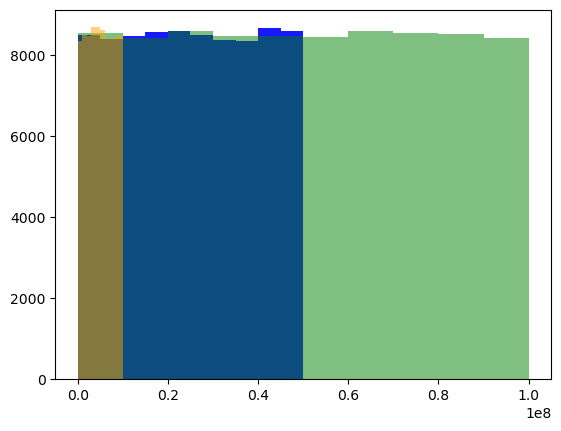

In [71]:
plt.hist(DATA_RETAIL_TABLE["AMT_PURCHASES_EDU"], color = "blue", alpha = 0.9)
plt.hist(DATA_RETAIL_TABLE["AMT_PURCHASES_CULTURE"], color = "green", alpha = 0.5)
plt.hist(DATA_RETAIL_TABLE["AMT_PURCHASES_BOOKS"], color = "orange", alpha = 0.5)
plt.show()

## 가명결합